In [12]:
import numpy as np
import pygad
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torchvision

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = "cpu"

# 1) Fetch MNIST, filter digits 0–4, and split:
#mnist = fetch_openml('mnist_784', version=1)
import torchvision.transforms as transforms

train_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

X_train = train_data.data.numpy()
y_train = train_data.targets.numpy()
X_test = test_data.data.numpy()
y_test = test_data.targets.numpy()


# Convert numpy to torch tensors:
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test,  dtype=torch.long).to(device)

# 2) Simple PyTorch model:
class SimpleNet(nn.Module):
    def __init__(self, hidden_units=64, activation=0):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_units)
        self.activation = [nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU()][activation]
        self.fc2 = nn.Linear(hidden_units, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# 3) Training + evaluation in a function:
def train_and_evaluate(hidden_units, learning_rate, epochs, activation):
    model = SimpleNet(hidden_units, activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Train:
    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()
    # Evaluate:
    with torch.no_grad():
        preds = model(X_test_t).argmax(dim=1)
        accuracy = (preds == y_test_t).float().mean().item()
    return accuracy

def fitness_func(instance, solution, sol_idx):
    hidden_units = int(solution[0])
    learning_rate = float(solution[1])
    epochs = int(solution[2])
    activation = int(solution[3])
    accuracy = train_and_evaluate(hidden_units, learning_rate, epochs, activation)
    return accuracy  # maximizing accuracy

# 4) Setup gene space and run GA:
gene_space = [
    range(16, 1025, 16),              # hidden_units
    np.arange(0.001, 10, 0.01),    # learning_rate
    np.arange(1,100,1),                 # epochs
    np.arange(0, 4, 1)                   # activation
]
#print("Gene space:", gene_space, "length:", len(gene_space))

num_generations = 10
with tqdm.tqdm(total=num_generations) as pbar:
    ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=3,
    fitness_func=fitness_func,
    sol_per_pop=5,
    num_genes=len(gene_space),
    gene_space=gene_space,
    mutation_type=None,
    on_generation=lambda _: pbar.update(1))
    ga_instance.run()

100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


Best solution parameters: [416.      8.311  91.      3.   ]
Best fitness (accuracy): 0.7556999921798706


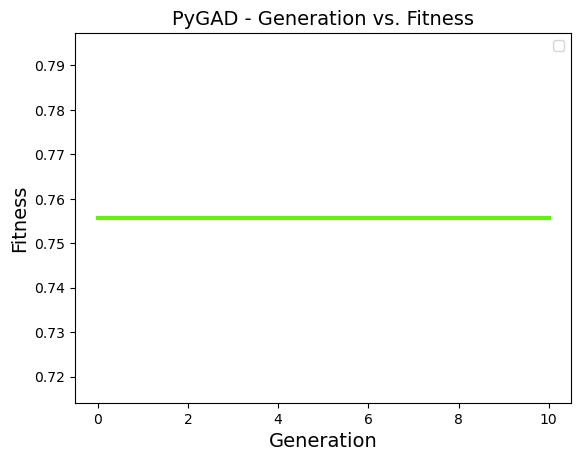

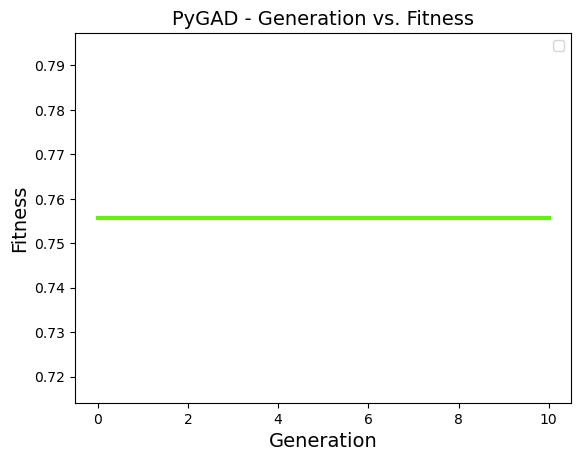

In [13]:
#ga_instance.run()
best_solution, best_solution_fitness, _ = ga_instance.best_solution()
print("Best solution parameters:", best_solution)
print("Best fitness (accuracy):", best_solution_fitness)
ga_instance.plot_fitness()